In [1]:
import pandas as pd
from pyworkforce.queuing import MultiErlangC, ErlangC
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

## Testing for single period ErlangC

In [60]:
def compute_staffing_levels(demand, aht, asa, interval, shrinkage, service_level, max_occupancy):
    demand = demand
    aht = aht
    asa = asa
    interval = interval
    shrinkage = shrinkage
    service_level = service_level
    max_occupancy = max_occupancy


    erlangC_formula = ErlangC(demand, aht, asa, interval, shrinkage)
    positions_requirements = erlangC_formula.required_positions(service_level=service_level, max_occupancy=max_occupancy)
    df = pd.DataFrame(positions_requirements, index=[0])
    staffing_levels = df
    staffing_levels['Number of surgeries'] = demand
    staffing_levels.columns = ["Raw Staffing Level", "Staffing Level",
                                "Service Level (%)", "Occupancy (%)", "Waiting Probability (%)", "Number of Surgeries"]

    percentage_columns = ["Service Level (%)", "Occupancy (%)", "Waiting Probability (%)"]
    pd.options.display.float_format = '{:,.2f}'.format
    staffing_levels[percentage_columns] = staffing_levels[percentage_columns].apply(lambda x: x*100)
    staffing_levels = staffing_levels.round(2)
    return staffing_levels

In [63]:
# DEFAULT SCENARIO PARAMETERS - OK 
params = {"service_level" : 0.9,
        "shrinkage" :       0.4,
        "max_occupancy" :   0.8,
        "asa" :             8,
        "aht":              2,
        'interval':         8}

interval = value = params['interval']
service_level = value= params["service_level"]
asa = value = params["asa"]
aht = value = params["aht"]
shrinkage = value = params["shrinkage"]
max_occupancy = value = params["max_occupancy"]
demand = int(1100/365)


staffing_levels = compute_staffing_levels(demand = demand,
                                          aht = aht,
                                          asa=asa,
                                          interval=interval,
                                          shrinkage=shrinkage,
                                          service_level=service_level,
                                          max_occupancy=max_occupancy)

## Testing for MultiErlangC

In [43]:
st.cache_data()
def compute_staffing_levels(demand, aht, interval, asa, shrinkage, service_level, max_occupancy):
   
    param_grid = {
        "transactions": demand, 
        "aht": aht, 
        "interval": interval, 
        "asa": asa, 
        "shrinkage": shrinkage        
    }
   
    multi_erlang = MultiErlangC(param_grid=param_grid, n_jobs=-1)
    required_positions_scenarios = {"service_level": service_level, "max_occupancy": max_occupancy}
    positions_requirements = multi_erlang.required_positions(required_positions_scenarios)
    df = pd.DataFrame.from_dict(positions_requirements)
    df.index = demand.index
    staffing_levels = pd.concat([demand, df], axis=1)
    staffing_levels.columns = ["Number of surgeries", "Raw Staffing Level", "Staffing Level",
                               "Service Level (%)", "Occupancy (%)", "Waiting Probability (%)"]
    
    percentage_columns = ["Service Level (%)", "Occupancy (%)", "Waiting Probability (%)"]
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    staffing_levels[percentage_columns] = staffing_levels[percentage_columns].apply(lambda x: x*100)
    staffing_levels = staffing_levels.round(2)
    return staffing_levels


def create_staffing_levels_average_week_plot(staffing_levels: pd.DataFrame, month:str, observed_kpi: str):
    
    if month == 'All':
        staffing_levels = staffing_levels
    else:
        staffing_levels = staffing_levels[staffing_levels['Month'] == month]
    staffing_levels.drop('Month',axis=1, inplace=True)


    # Create average week
    staffing_levels = staffing_levels.groupby(staffing_levels.index.dayofweek).mean().round().reset_index(drop =False, names = ["Day", "Hour", "Minute"])
    days = ["Monday ", "Tuesday ", "Wednesday ", "Thursday " , "Friday ", "Saturday ", "Sunday "]
    staffing_levels["Day"] = staffing_levels["Day"].apply(lambda x: days[x])

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

    # Plot the time series
    plt.plot(staffing_levels['Day'], staffing_levels[observed_kpi], label=observed_kpi)

    # Set labels and title
    plt.xlabel('Average Week')
    plt.ylabel(observed_kpi)
    plt.title(f'Time Series Plot of {observed_kpi}')
    plt.ylim(0, staffing_levels[observed_kpi].max() + 5)
    plt.legend()
    plt.show()




In [44]:
# Generate date range for the entire year
start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-12-31")
date_range = pd.date_range(start_date, end_date)

# Create DataFrame with random demand values
df = pd.DataFrame(index=date_range)
df['demand'] = np.random.randint(1, 8, size=len(date_range))


# Set the index to represent Monday to Sunday
# df['weekday'] = df.index.day_name()
# weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)
#df = df.sort_values(by='weekday')
demand_df = df

In [47]:
# DEFAULT SCENARIO PARAMETERS - OK 
params = {"service_level" : [0.9],
        "shrinkage" :       [0.4],
        "max_occupancy" :   [0.8],
        "asa" :             [2],
        "aht":              [2],
        'interval':         [8]}

interval = value = params['interval']
service_level = value= params["service_level"]
asa = value = params["asa"]
aht = value = params["aht"]
shrinkage = value = params["shrinkage"]
max_occupancy = value = params["max_occupancy"]
demand = demand_df.demand


staffing_levels = compute_staffing_levels(demand = demand,
                                          aht = aht,
                                          asa=asa,
                                          interval=interval,
                                          shrinkage=shrinkage,
                                          service_level=service_level,
                                          max_occupancy=max_occupancy)
staffing_levels['Month'] = staffing_levels.index.strftime('%B')

,Number of surgeries,Raw Staffing Level,Staffing Level,Service Level (%),Occupancy (%),Waiting Probability (%),Month
2024-01-01,5,3,5,97.30,41.67,15.55,January
2024-01-02,4,3,5,98.77,33.33,9.09,January
2024-01-03,7,3,5,90.44,58.33,33.37,January
2024-01-04,2,2,4,97.77,25.00,10.00,January
2024-01-05,2,2,4,97.77,25.00,10.00,January
...,...,...,...,...,...,...,...
2024-12-27,4,3,5,98.77,33.33,9.09,December
2024-12-28,6,3,5,94.72,50.00,23.68,December
2024-12-29,4,3,5,98.77,33.33,9.09,December
2024-12-30,6,3,5,94.72,50.00,23.68,December


C:\Users\Consumer\AppData\Local\Temp\ipykernel_15956\2818416561.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  staffing_levels.drop('Month',axis=1, inplace=True)


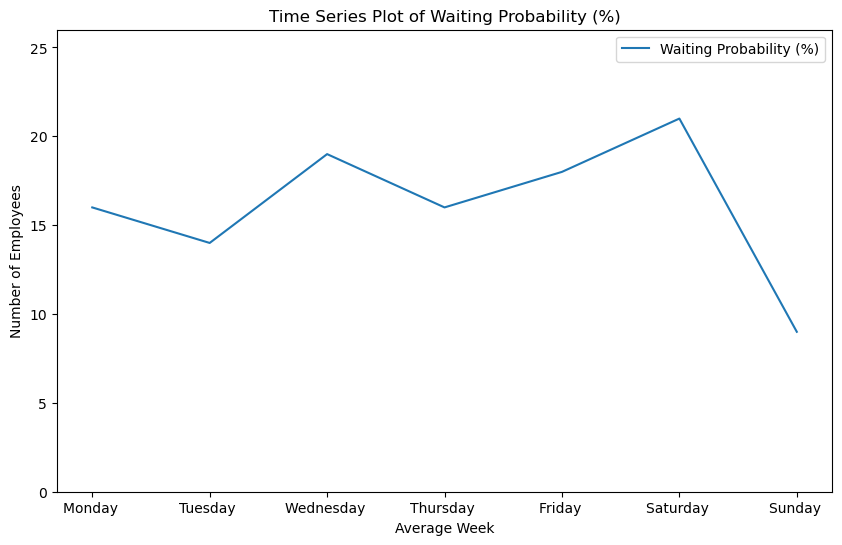

In [49]:
display(staffing_levels)
create_staffing_levels_average_week_plot(staffing_levels, 'July', 'Waiting Probability (%)')